# Unsupervised Domain Adaptation

#### Installing the required libraries

In [1]:
!pip install torchinfo

#### Loading in the required libraries

In [2]:
import torch
import torch.nn as nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
from torchvision.datasets import MNIST, USPS, SVHN
from torchinfo import summary
from tqdm import tqdm
import torch.optim as optim
from sklearn.manifold import TSNE
import numpy as np
import random

#### Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Setting the drive path to the folder

In [ ]:
path = '/content/drive/MyDrive/ATML_PA5'
# Setting the path to this folder
os.chdir(path)
# Checking the current working directory
print(os.getcwd())

/content/drive/MyDrive/ATML_PA5


#### Setting the device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("The device is: ", device)

The device is:  cuda


## Loading in the dataset

#### OFFICE-31 dataset

In [ ]:
data_path = 'OFFICE31'
amazon_path = os.path.join(data_path, 'amazon')
webcam_path = os.path.join(data_path, 'webcam')
dslr_path = os.path.join(data_path, 'dslr')

print('amazon_path:', amazon_path)
print('webcam_path:', webcam_path)
print('dslr_path:', dslr_path)

# Defining the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Loading in the datasets for each of the domains
amazon_dataset = datasets.ImageFolder(amazon_path, transform=transform)
webcam_dataset = datasets.ImageFolder(webcam_path, transform=transform)
dslr_dataset = datasets.ImageFolder(dslr_path, transform=transform)

# Defining the dataloaders
batch_size = 64
amazon_dataloader = DataLoader(amazon_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
webcam_dataloader = DataLoader(webcam_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
dslr_dataloader = DataLoader(dslr_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Checking the size of the datasets
print('Amazon dataset size:', len(amazon_dataset))
print('Webcam dataset size:', len(webcam_dataset))
print('DSLR dataset size:', len(dslr_dataset))

amazon_path: OFFICE31/amazon
webcam_path: OFFICE31/webcam
dslr_path: OFFICE31/dslr
Amazon dataset size: 2817
Webcam dataset size: 795
DSLR dataset size: 498


#### Digits datasets

In [4]:
# Define transformations for the datasets
transform_mnist_usps = transforms.Compose([
    transforms.Resize((224, 224)),                  # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),  # Ensure grayscale images (for USPS/MNIST) and convert to 3 channels
    transforms.ToTensor(),                        # Convert to Tensor
    transforms.Normalize((0.5,), (0.5,))          # Normalize to [-1, 1]
])

transform_svhn = transforms.Compose([
    transforms.Resize((224, 224)),                  # Resize to 224x224
    transforms.ToTensor(),                        # Convert to Tensor
    transforms.Normalize((0.5,), (0.5,))          # Normalize to [-1, 1]
])

batch_size = 64

# Loading in MNIST dataset
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform_mnist_usps)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform_mnist_usps)

# MNIST dataloaders
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Loading in the USPS dataset
usps_train = USPS(root='./data', train=True, download=True, transform=transform_mnist_usps)
usps_test = USPS(root='./data', train=False, download=True, transform=transform_mnist_usps)

# USPS dataloaders
usps_train_loader = DataLoader(usps_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
usps_test_loader = DataLoader(usps_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Loading in the SVHN dataset
svhn_train = SVHN(root='./data', split='train', download=True, transform=transform_svhn)
svhn_test = SVHN(root='./data', split='test', download=True, transform=transform_svhn)

# SVHN dataloaders
svhn_train_loader = DataLoader(svhn_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
svhn_test_loader = DataLoader(svhn_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Print dataset sizes for verification
print(f"MNIST Train Size: {len(mnist_train)}")
print(f"MNIST Test Size: {len(mnist_test)}")
print(f"USPS Train Size: {len(usps_train)}")
print(f"USPS Test Size: {len(usps_test)}")
print(f"SVHN Train Size: {len(svhn_train)}")
print(f"SVHN Test Size: {len(svhn_test)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 534kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


100%|██████████| 6.58M/6.58M [00:12<00:00, 515kB/s] 


100%|██████████| 1.83M/1.83M [00:02<00:00, 704kB/s]


100%|██████████| 182M/182M [00:06<00:00, 26.5MB/s]


100%|██████████| 64.3M/64.3M [00:01<00:00, 34.5MB/s]


MNIST Train Size: 60000
MNIST Test Size: 10000
USPS Train Size: 7291
USPS Test Size: 2007
SVHN Train Size: 73257
SVHN Test Size: 26032


#### Visualizing images from each domain

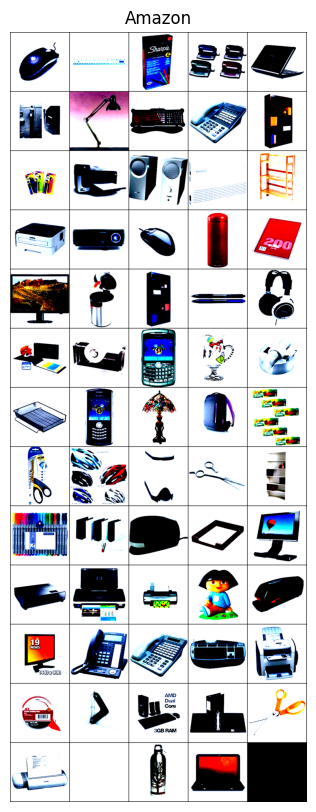

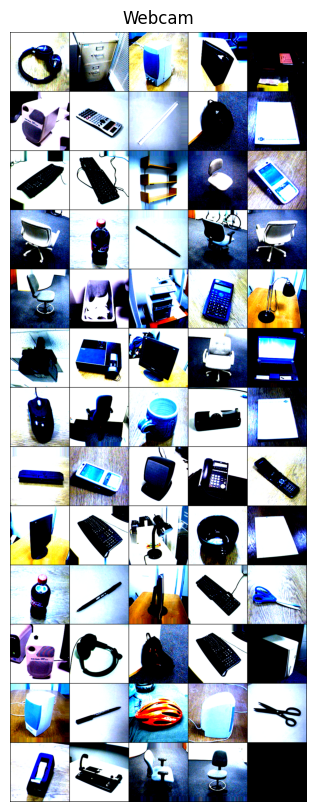

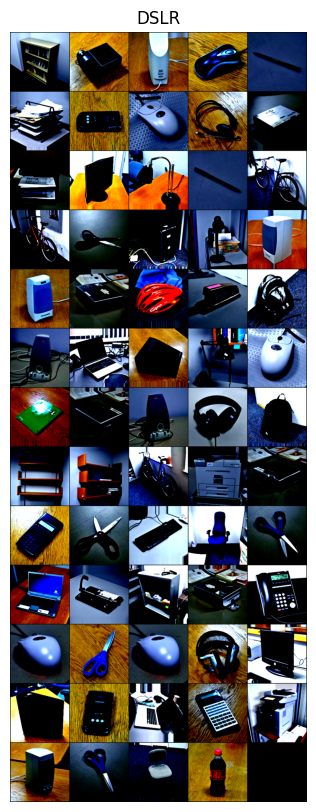

In [ ]:
# Visualizing 5 images from each of the domains
def show_images(dataloader, domain_name):
    images, _ = next(iter(dataloader))
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(domain_name)
    plt.imshow(make_grid(images, nrow=5).permute(1, 2, 0))
    plt.show()

show_images(amazon_dataloader, 'Amazon')
show_images(webcam_dataloader, 'Webcam')
show_images(dslr_dataloader, 'DSLR')

#### Creating a small subsets of the dataloaders for experiments before scaling

In [5]:
# Function to create a subset
def create_subset(dataset, subset_size, seed=42):
    """
    Creates a random subset of the dataset.

    Args:
        dataset (Dataset): The original dataset.
        subset_size (int): The number of samples in the subset.
        seed (int): Random seed for reproducibility.

    Returns:
        Subset: A PyTorch Subset object.
    """
    random.seed(seed)
    indices = random.sample(range(len(dataset)), subset_size)
    return Subset(dataset, indices)

# Create subsets of the train and test datasets
mnist_train_subset = create_subset(mnist_train, 1000)
mnist_test_subset = create_subset(mnist_test, 1000)
usps_train_subset = create_subset(usps_train, 1000)
usps_test_subset = create_subset(usps_test, 1000)
svhn_train_subset = create_subset(svhn_train, 1000)
svhn_test_subset = create_subset(svhn_test, 1000)

# Creating the subset dataloaders
mnist_train_subset_loader = DataLoader(mnist_train_subset, batch_size=batch_size, shuffle=True)
mnist_test_subset_loader = DataLoader(mnist_test_subset, batch_size=batch_size, shuffle=False)
usps_train_subset_loader = DataLoader(usps_train_subset, batch_size=batch_size, shuffle=True)
usps_test_subset_loader = DataLoader(usps_test_subset, batch_size=batch_size, shuffle=False)
svhn_train_subset_loader = DataLoader(svhn_train_subset, batch_size=batch_size, shuffle=True)
svhn_test_subset_loader = DataLoader(svhn_test_subset, batch_size=batch_size, shuffle=False)


# Check the size of the subsets
print(f"MNIST Train Subset Size: {len(mnist_train_subset)}")
print(f"MNIST Test Subset Size: {len(mnist_test_subset)}")
print(f"USPS Train Subset Size: {len(usps_train_subset)}")
print(f"USPS Test Subset Size: {len(usps_test_subset)}")
print(f"SVHN Train Subset Size: {len(svhn_train_subset)}")
print(f"SVHN Test Subset Size: {len(svhn_test_subset)}")


MNIST Train Subset Size: 1000
MNIST Test Subset Size: 1000
USPS Train Subset Size: 1000
USPS Test Subset Size: 1000
SVHN Train Subset Size: 1000
SVHN Test Subset Size: 1000


## ResNet 50 Experiments

#### Loading in the ResNet 50 model and modifying the feature extractor backbone for Office 31 classification

In [6]:
# Loading in the resnet model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Checking the model summary
summary(model, input_size=(1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

#### Modifying the feature extractor

In [7]:
# num_classes = len(amazon_dataset.classes)
num_classes = len(mnist_train.classes)
print("The number of classes is: ", num_classes)

# Modifying the final layer of the model to output the number of classes
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes)
# Sending the updated model to the device
model = model.to(device)

# Checking the updated model summary to verify the changes
summary(model, input_size=(1, 3, 224, 224))

The number of classes is:  10


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [8]:
# Single function for loading in the resnet model and modifying the final layer
def load_resnet_model(num_classes):
    # model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    model = resnet50()
    # # Freeze all layers except the final layer
    # for param in model.parameters():
    #     param.requires_grad = False

    # Replace the fully connected (fc) layer
    model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes)

    # # Ensure the parameters in the final layer are trainable
    # for param in model.fc.parameters():
    #     param.requires_grad = True

    # Move the model to the specified device
    model = model.to(device)

    return model

# Loading in the resnet model with the updated final layer
model = load_resnet_model(num_classes)

# Sending the model to the device
model = model.to(device)

# Checking the model summary
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

#### Defining the function for training and testing

In [9]:
# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function
def train_model(model, dataloader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

    # Calculate and return average training loss and accuracy for the epoch
    train_loss = running_loss / len(dataloader)
    # Assuming you have a way to calculate train_accuracy (add your logic here)
    train_accuracy = 0  # Replace with your accuracy calculation

    return train_loss, train_accuracy  # Return loss and accuracy

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    """
    Train and evaluate a model in a loop for a specified number of epochs.

    Args:
        model (torch.nn.Module): The model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (Loss): The loss function (e.g., CrossEntropyLoss).
        optimizer (Optimizer): The optimizer (e.g., Adam, SGD).
        device (torch.device): The device to use (e.g., 'cuda' or 'cpu').
        num_epochs (int): Number of epochs for training.

    Returns:
        None
    """

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Train the model
        print("Training...")
        # Corrected the order of arguments here
        train_loss, train_accuracy = train_model(model, train_loader, optimizer, criterion, num_epochs=num_epochs)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Evaluate the model
        print("Evaluating...")
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        print("-" * 50)

#### First experiment M -> U
<!-- A -> W -->

In [ ]:
model_M_to_U = load_resnet_model(num_classes)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_M_to_U.parameters(), lr=0.001)

# Train the model
train_model(model_M_to_U, mnist_train_subset_loader, optimizer, criterion, 5)

# Evaluating on the USPS data
evaluate_model(model_M_to_U, usps_test_subset_loader)

# Training the model on the MNIST dataset
# train_model(model_M_to_U, mnist_train_loader, optimizer, criterion, num_epochs=5)
# train_model(model_M_to_U, mnist_subset_loader, optimizer, criterion, num_epochs=5)

# Evaluating the model on the USPS dataset
# evaluate_model(model_M_to_U, usps_test_loader)

# # Training the model on the Amazon dataset
# train_model(model_A_to_W, amazon_dataloader, optimizer, criterion, num_epochs=5)

# # Evaluating the model on the Webcam dataset
# evaluate_model(model_A_to_W, webcam_dataloader)

Epoch 1/5: 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]


Epoch [1/5], Loss: 1.8504


Epoch 2/5: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


Epoch [2/5], Loss: 0.4493


Epoch 3/5: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


Epoch [3/5], Loss: 0.2115


Epoch 4/5: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


Epoch [4/5], Loss: 0.1539


Epoch 5/5: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


Epoch [5/5], Loss: 0.0814


Evaluating: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]

Accuracy: 9.30%


9.3

In [ ]:
# Saving the trained digit model M -> U
# torch.save(model_A_to_W, 'baseline_model_mnist_to_usps.pth')

In [ ]:
# Saving the trained model
# torch.save(model_A_to_W, 'baseline_model_amazon_to_webcam.pth')

#### Loading in the saved model and doing feature visualization

In [10]:
# Define the feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])  # All layers except the final FC layer

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)  # Flatten the feature map

# Main function for feature extraction, t-SNE, and visualization
def visualize_features_with_tsne(model, source_dataloader, target_dataloader, source_label="Source", target_label="Target"):
    """
    Visualizes features from source and target datasets using t-SNE.

    Args:
        model (nn.Module): The fine-tuned model to extract features from.
        source_dataloader (DataLoader): DataLoader for the source dataset.
        target_dataloader (DataLoader): DataLoader for the target dataset.
        source_label (str): Label for the source dataset in the plot.
        target_label (str): Label for the target dataset in the plot.
    """
    # Create a feature extractor
    feature_extractor = FeatureExtractor(model).to(device)
    feature_extractor.eval()

    def extract_features(dataloader):
        features = []
        labels = []
        with torch.no_grad():
            for images, lbls in dataloader:
                images = images.to(device)
                outputs = feature_extractor(images)
                features.append(outputs.cpu().numpy())
                labels.append(lbls.numpy())
        return np.concatenate(features), np.concatenate(labels)

    # Extract features for source and target
    print(f"Extracting features from {source_label}...")
    source_features, _ = extract_features(source_dataloader)

    print(f"Extracting features from {target_label}...")
    target_features, _ = extract_features(target_dataloader)

    # Combine features for t-SNE
    features = np.vstack((source_features, target_features))
    domains = np.array([source_label] * len(source_features) + [target_label] * len(target_features))

    # Apply t-SNE
    print("Applying t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    features_2d = tsne.fit_transform(features)

    # Plot t-SNE results
    plt.figure(figsize=(10, 7))
    for domain, color in zip([source_label, target_label], ['blue', 'red']):
        indices = domains == domain
        plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=domain, alpha=0.6, s=10, c=color)

    plt.title(f"t-SNE Visualization of {source_label} and {target_label} Features")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.show()

# Visualize features
# visualize_features_with_tsne(model_M_to_U, mnist_train_subset_loader, usps_test_subset_loader, source_label="MNIST", target_label="USPS")

#### M -> U Feature Distribution

Extracting features from MNIST...
Extracting features from USPS...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


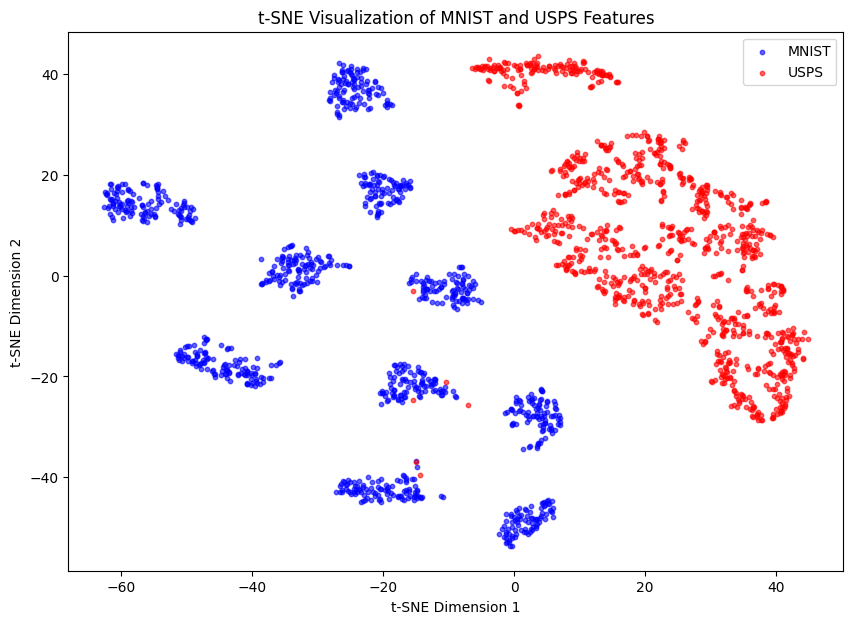

In [ ]:
visualize_features_with_tsne(model_M_to_U, mnist_train_subset_loader, usps_test_subset_loader, source_label="MNIST", target_label="USPS")

#### Second experiment U -> M

In [ ]:
model_U_to_M = load_resnet_model(num_classes)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_U_to_M.parameters(), lr=0.001)

# Train the model
train_model(model_U_to_M, usps_train_subset_loader, optimizer, criterion, 5)

# Evaluating on the USPS data
evaluate_model(model_U_to_M, mnist_test_subset_loader)

Epoch 1/5: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


Epoch [1/5], Loss: 1.9448


Epoch 2/5: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


Epoch [2/5], Loss: 0.5822


Epoch 3/5: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


Epoch [3/5], Loss: 0.1906


Epoch 4/5: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


Epoch [4/5], Loss: 0.1198


Epoch 5/5: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


Epoch [5/5], Loss: 0.1139


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]

Accuracy: 14.70%


14.7

#### U -> M Feature Distribution

Extracting features from USPS...
Extracting features from MNIST...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


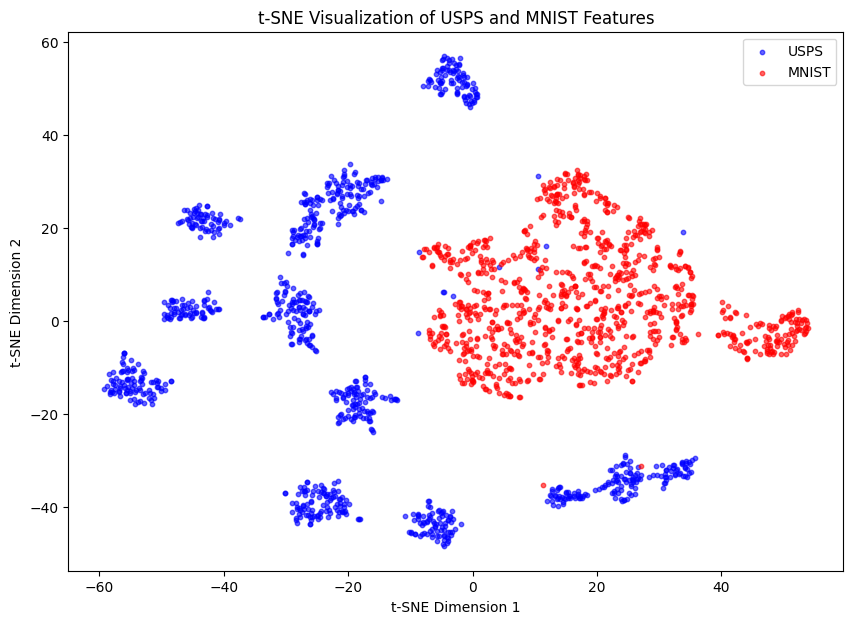

In [ ]:
visualize_features_with_tsne(model_U_to_M, usps_train_subset_loader, mnist_train_subset_loader, source_label="USPS", target_label="MNIST")

#### Third experiment S -> M

In [ ]:
model_S_to_M = load_resnet_model(num_classes)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_S_to_M.parameters(), lr=0.001)

# Train the model
train_model(model_S_to_M, svhn_train_subset_loader, optimizer, criterion, 5)

# Evaluating on the USPS data
evaluate_model(model_S_to_M, mnist_test_subset_loader)

Epoch 1/5: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Epoch [1/5], Loss: 3.0042


Epoch 2/5: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Epoch [2/5], Loss: 2.4435


Epoch 3/5: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Epoch [3/5], Loss: 2.3323


Epoch 4/5: 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


Epoch [4/5], Loss: 2.2920


Epoch 5/5: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


Epoch [5/5], Loss: 2.3013


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]

Accuracy: 11.20%


11.200000000000001

S -> M Feature Distribution

Extracting features from SVHN...
Extracting features from MNIST...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


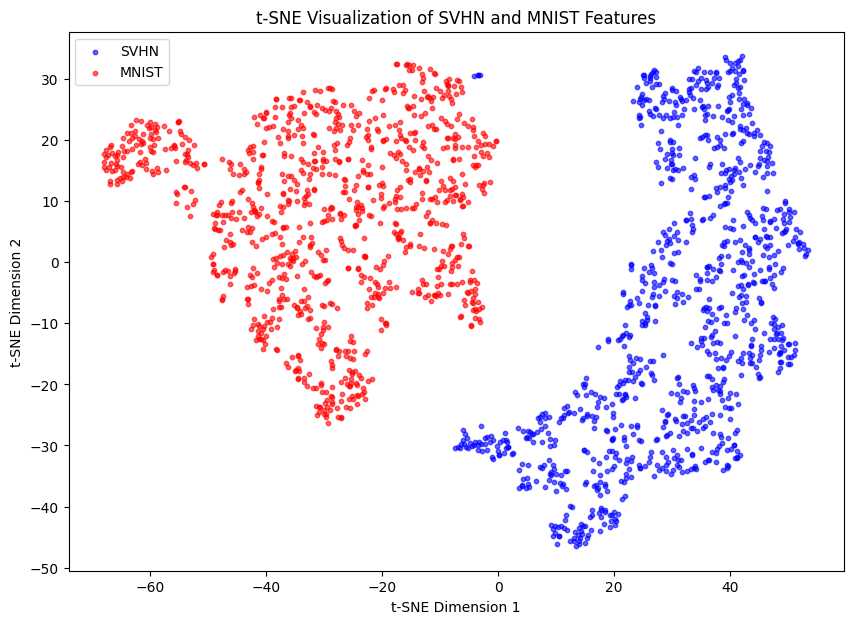

In [ ]:
visualize_features_with_tsne(model_U_to_M, svhn_train_subset_loader, mnist_train_subset_loader, source_label="SVHN", target_label="MNIST")

## DAN Architecture

#### Defining the MMD Loss

In [11]:
def compute_mmd_loss(source_features, target_features):
    """
    Compute the Maximum Mean Discrepancy (MMD) loss between source and target features.
    """
    source_mean = torch.mean(source_features, dim=0)
    target_mean = torch.mean(target_features, dim=0)
    mmd_loss = torch.norm(source_mean - target_mean, p=2)  # L2 norm
    return mmd_loss

#### Creating the DAN class by modifying ResNet backbone

In [12]:
class DAN(nn.Module):
    def __init__(self, num_classes):
        super(DAN, self).__init__()
        self.backbone = resnet50()
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # New classification head
        self.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return features, outputs

#### DAN training loop

In [13]:
def train_dan(model, source_loader, target_loader, criterion, optimizer, device, num_epochs):
    """
    Train the DAN model with classification and MMD loss.
    """
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        source_iter = iter(source_loader)
        target_iter = iter(target_loader)

        for i in tqdm(range(len(source_loader)), desc=f"Epoch {epoch + 1}/{num_epochs}"):
            # Get source and target batches
            source_images, source_labels = next(source_iter)
            target_images, _ = next(target_iter, (None, None))  # Target labels not used

            source_images, source_labels = source_images.to(device), source_labels.to(device)
            target_images = target_images.to(device)

            # Forward pass
            source_features, source_logits = model(source_images)
            target_features, _ = model(target_images)

            # Compute losses
            classification_loss = criterion(source_logits, source_labels)
            mmd_loss = compute_mmd_loss(source_features, target_features)
            total_loss = classification_loss + mmd_loss  # Combine losses

            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += total_loss.item() * source_images.size(0)
            _, preds = torch.max(source_logits, 1)
            correct += (preds == source_labels).sum().item()
            total += source_labels.size(0)

        epoch_loss = running_loss / total
        epoch_accuracy = 100.0 * correct / total

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

def evaluate_model_dan(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass - get the second element of the tuple which are the outputs
            _, outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    return accuracy

#### DAN first experiment M->U

In [20]:
# Initialize the model
num_classes = 10  # Number of classes in MNIST/USPS
model = DAN(num_classes).to(device)

# Define the loss, optimizer, and DataLoaders
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Subset loaders for testing
source_loader = mnist_train_subset_loader
target_loader = usps_train_subset_loader

# Train the DAN model
train_dan(model, source_loader, target_loader, criterion, optimizer, device, num_epochs=10)

# Evaluate the model on target domain
val_accuracy = evaluate_model_dan(model, usps_test_subset_loader)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")


Epoch 1/15: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


Epoch 1/15, Loss: 3.8746, Accuracy: 12.90%


Epoch 2/15: 100%|██████████| 16/16 [00:23<00:00,  1.46s/it]


Epoch 2/15, Loss: 2.4669, Accuracy: 27.50%


Epoch 3/15: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


Epoch 3/15, Loss: 1.9676, Accuracy: 39.60%


Epoch 4/15: 100%|██████████| 16/16 [00:22<00:00,  1.41s/it]


Epoch 4/15, Loss: 1.6768, Accuracy: 52.40%


Epoch 5/15: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


Epoch 5/15, Loss: 1.3609, Accuracy: 60.20%


Epoch 6/15: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


Epoch 6/15, Loss: 1.2416, Accuracy: 66.70%


Epoch 7/15: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


Epoch 7/15, Loss: 0.9373, Accuracy: 77.90%


Epoch 8/15: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


Epoch 8/15, Loss: 0.8546, Accuracy: 82.60%


Epoch 9/15: 100%|██████████| 16/16 [00:22<00:00,  1.41s/it]


Epoch 9/15, Loss: 0.6462, Accuracy: 90.10%


Epoch 10/15: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


Epoch 10/15, Loss: 0.5442, Accuracy: 92.10%


Epoch 11/15: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


Epoch 11/15, Loss: 0.4357, Accuracy: 95.30%


Epoch 12/15: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


Epoch 12/15, Loss: 0.3728, Accuracy: 94.90%


Epoch 13/15: 100%|██████████| 16/16 [00:23<00:00,  1.45s/it]


Epoch 13/15, Loss: 0.2769, Accuracy: 98.70%


Epoch 14/15: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it]


Epoch 14/15, Loss: 0.2249, Accuracy: 99.10%


Epoch 15/15: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


Epoch 15/15, Loss: 0.1859, Accuracy: 99.70%
Target Domain Evaluation - Accuracy: 31.80%


#### DAN M->U Feature Alignment check

Extracting features from MNIST...
Extracting features from USPS...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


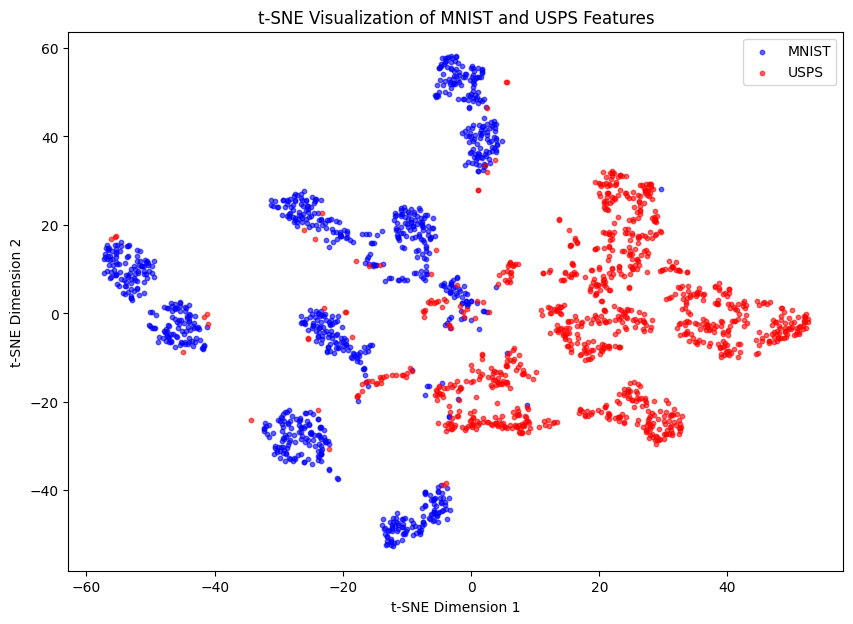

In [23]:
visualize_features_with_tsne(model, mnist_train_subset_loader, usps_test_subset_loader, source_label="MNIST", target_label="USPS")

#### DAN second experiment U -> M

In [14]:
# Initialize the model
num_classes = 10  # Number of classes in MNIST/USPS
model = DAN(num_classes).to(device)

# Define the loss, optimizer, and DataLoaders
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Subset loaders for testing
source_loader = usps_train_subset_loader
target_loader = mnist_train_subset_loader

# Train the DAN model
train_dan(model, source_loader, target_loader, criterion, optimizer, device, num_epochs=10)

# Evaluate the model on target domain
val_accuracy = evaluate_model_dan(model, mnist_test_subset_loader)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

Epoch 1/10: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


Epoch 1/10, Loss: 3.6099, Accuracy: 23.50%


Epoch 2/10: 100%|██████████| 16/16 [00:23<00:00,  1.45s/it]


Epoch 2/10, Loss: 2.1208, Accuracy: 45.80%


Epoch 3/10: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


Epoch 3/10, Loss: 1.6396, Accuracy: 60.80%


Epoch 4/10: 100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


Epoch 4/10, Loss: 1.2942, Accuracy: 71.30%


Epoch 5/10: 100%|██████████| 16/16 [00:22<00:00,  1.41s/it]


Epoch 5/10, Loss: 0.9237, Accuracy: 81.70%


Epoch 6/10: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


Epoch 6/10, Loss: 0.8640, Accuracy: 84.20%


Epoch 7/10: 100%|██████████| 16/16 [00:23<00:00,  1.45s/it]


Epoch 7/10, Loss: 0.6466, Accuracy: 90.70%


Epoch 8/10: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


Epoch 8/10, Loss: 0.5390, Accuracy: 92.10%


Epoch 9/10: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


Epoch 9/10, Loss: 0.4959, Accuracy: 93.00%


Epoch 10/10: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]


Epoch 10/10, Loss: 0.4514, Accuracy: 94.40%
Target Domain Evaluation - Accuracy: 32.20%


#### DAN U -> M Feature Alignment Check

Extracting features from USPS...
Extracting features from MNIST...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


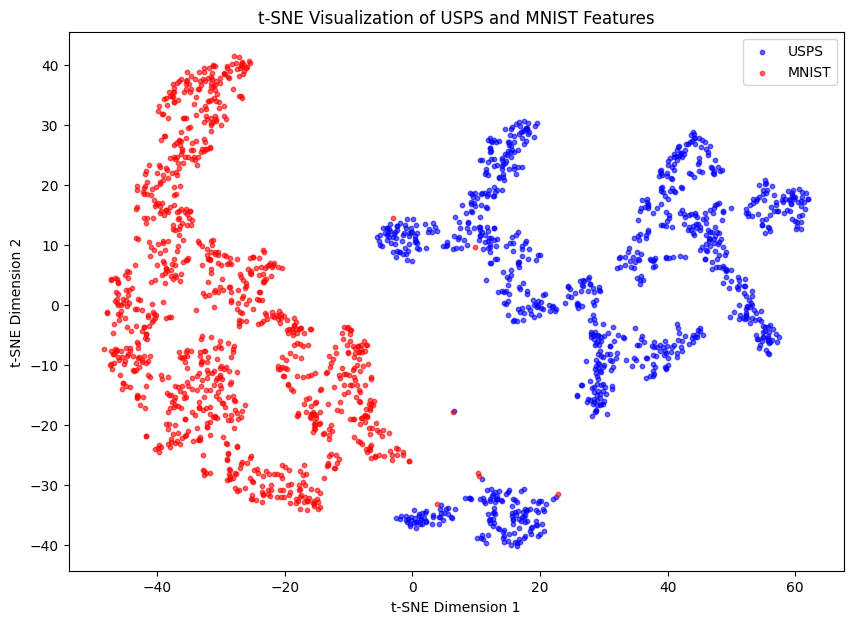

In [15]:
visualize_features_with_tsne(model, usps_train_subset_loader, mnist_test_subset_loader, source_label="USPS", target_label="MNIST")

#### DAN third experiment S -> M

In [16]:
# Initialize the model
num_classes = 10  # Number of classes in MNIST/USPS
model = DAN(num_classes).to(device)

# Define the loss, optimizer, and DataLoaders
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Subset loaders for testing
source_loader = svhn_train_subset_loader
target_loader = mnist_train_subset_loader

# Train the DAN model
train_dan(model, source_loader, target_loader, criterion, optimizer, device, num_epochs=10)

# Evaluate the model on target domain
val_accuracy = evaluate_model_dan(model, mnist_test_subset_loader)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

Epoch 1/10: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]


Epoch 1/10, Loss: 3.8645, Accuracy: 14.80%


Epoch 2/10: 100%|██████████| 16/16 [00:23<00:00,  1.46s/it]


Epoch 2/10, Loss: 3.0914, Accuracy: 17.60%


Epoch 3/10: 100%|██████████| 16/16 [00:22<00:00,  1.44s/it]


Epoch 3/10, Loss: 2.7115, Accuracy: 19.80%


Epoch 4/10: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


Epoch 4/10, Loss: 2.5322, Accuracy: 19.60%


Epoch 5/10: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]


Epoch 5/10, Loss: 2.3975, Accuracy: 18.40%


Epoch 6/10: 100%|██████████| 16/16 [00:22<00:00,  1.44s/it]


Epoch 6/10, Loss: 2.3418, Accuracy: 17.30%


Epoch 7/10: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


Epoch 7/10, Loss: 2.3089, Accuracy: 19.80%


Epoch 8/10: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


Epoch 8/10, Loss: 2.2927, Accuracy: 19.80%


Epoch 9/10: 100%|██████████| 16/16 [00:22<00:00,  1.44s/it]


Epoch 9/10, Loss: 2.2802, Accuracy: 19.80%


Epoch 10/10: 100%|██████████| 16/16 [00:22<00:00,  1.44s/it]


Epoch 10/10, Loss: 2.2762, Accuracy: 19.90%
Target Domain Evaluation - Accuracy: 12.30%


#### DAN S -> M Feature Alignment Check

Extracting features from SVHN...
Extracting features from MNIST...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


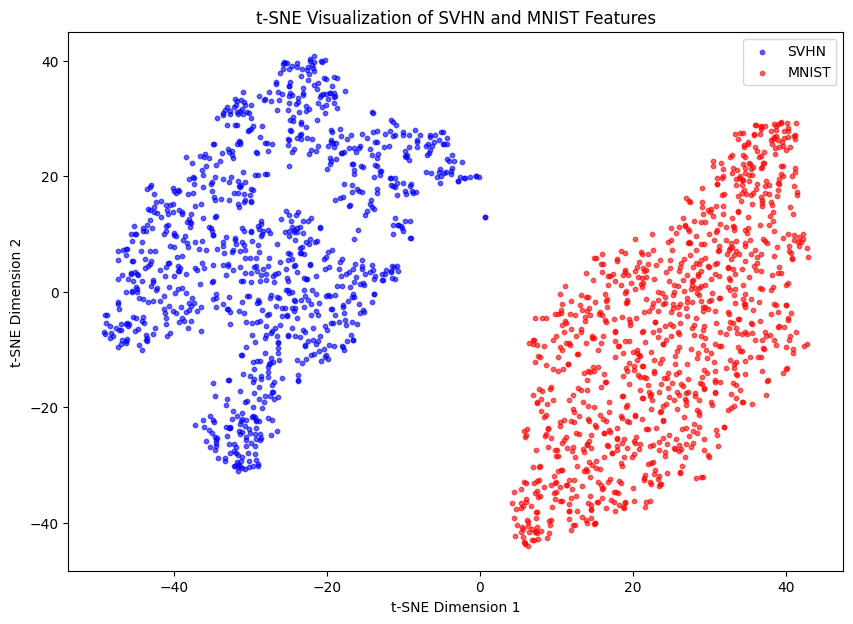

In [17]:
visualize_features_with_tsne(model, svhn_train_subset_loader, mnist_test_subset_loader, source_label="SVHN", target_label="MNIST")